In [2]:
%config InlineBackend.figure_format = 'retina'

# leaderboard

In [3]:
%run -n main
records = parse_tsv(LEADERBOARD_LINES)
leaderboard = list(parse_leaderboard(records))

# grid

## preds

In [34]:
# %run -n main
# task_tests = {
#     _: list(load_task(_, PUBLIC, TEST))
#     for _ in TASKS
# }

In [33]:
# %run -n main
# for conf in GRID_CONFS:
#     for task in TASKS:
#         exp_dir = find_grid_exp_dir(EXPS_DIR, conf.id, conf.model, task)
#         if not exp_dir:
#             log(f'missing {conf.id} {conf.model} {task}')
#             continue

#         if not grid_exp_finised(exp_dir, task):
#             log(f'unfinished {conf.id} {conf.model} {task}')
#             continue
            
#         if grid_preds_exist(conf.id, task):
#             continue

#         log('id: %r, task: %r', conf.id, task)
#         preds = infer_jiant(exp_dir, task, task_tests[task], batch_size=64)
#         dump_grid_preds(conf.id, task, preds)

## eval

In [35]:
%run -n main
task_targets = {
    _: list(load_task(_, PRIVATE, TEST))
    for _ in TASKS
}

In [15]:
%run -n main
conf_task_scores = []
for conf in log_progress(GRID_CONFS):
    for task in TASKS:
        if grid_preds_exist(conf.id, task):
            preds = list(load_grid_preds(conf.id, task))
            metrics = eval(task, preds, task_targets[task])
            score = select_score(task, metrics)
            conf_task_scores.append([conf.id, task, score])

## show

In [37]:
%run -n main
task_train_sizes = {
    _: sum(1 for _ in load_task(_, PUBLIC, TRAIN))
    for _ in TASKS
    if _ != LIDIRUS
}

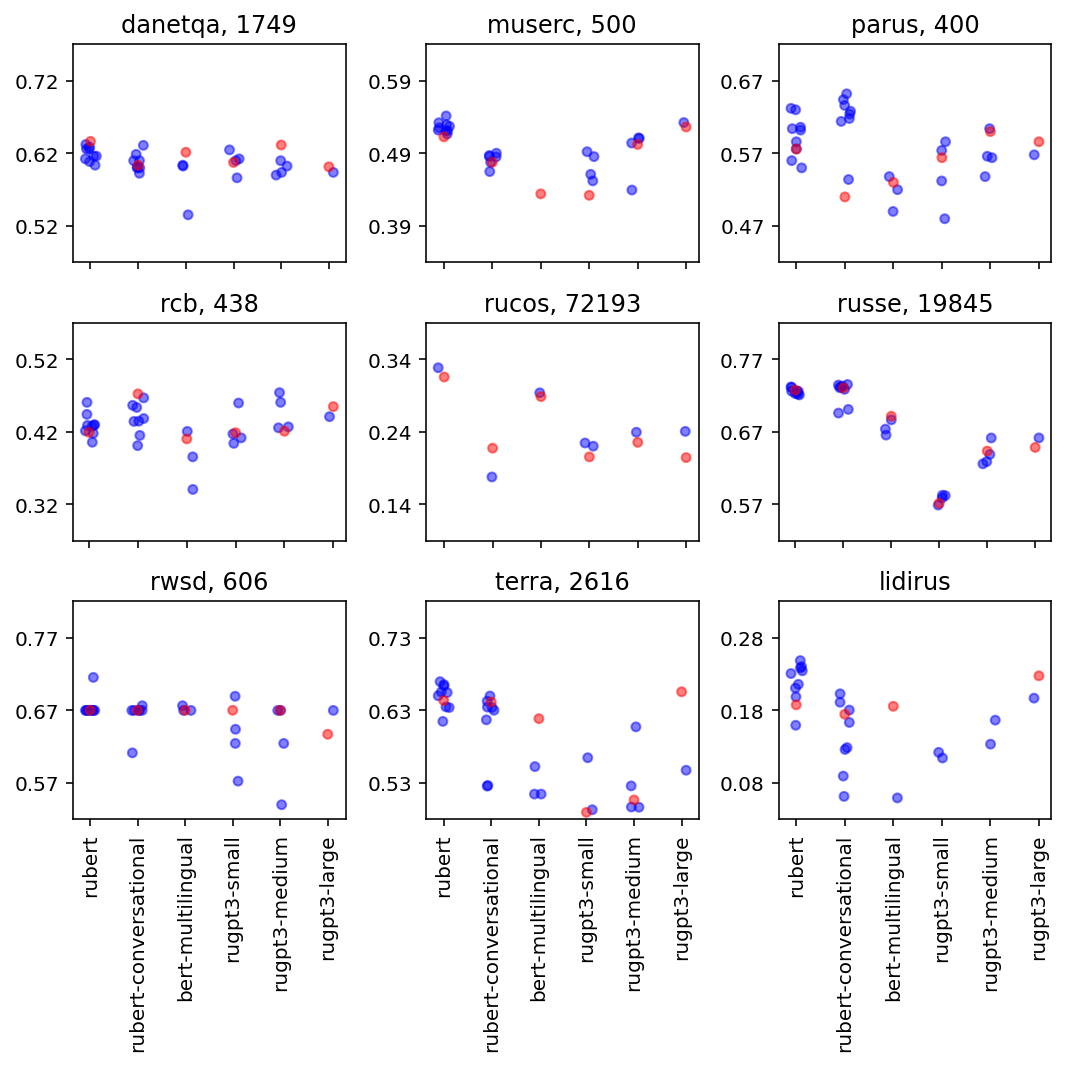

In [46]:
%run -n main
show_grid_scores(leaderboard, conf_task_scores, task_train_sizes)

## upload

In [52]:
# %run -n main
# for conf in GRID_CONFS:
#     print(f'python main.py s3 sync ~/exps/{conf.id}/{conf.model} //exps/{conf.id}')

# docker

## download top exps

In [10]:
# %run -n main
# for model in MODELS:
#     for task in TASKS:
#         if task == LIDIRUS:
#             continue

#         id = select_top_conf(task, model, conf_task_scores)
#         if not id:
#             log(f'missing {model} {task}')
#             continue
            
#         leaderboard_score = score_value(find_leaderboard_score(model, task, leaderboard))
#         grid_score = score_value(find_grid_score(id, task, conf_task_scores))
#         label = '!' if grid_score < leaderboard_score else ' '

#         print(f'{label} {leaderboard_score:0.3f} {grid_score:0.3f} {id} {task:<10} {model}')
#         print(f'python main.py s3 sync //exps/{id}/{task} exps/{model}/{task}')
#     print(f'python main.py s3 sync //exps/{id}/transformers_cache exps/{model}/transformers_cache')

## build

In [12]:
# selected = []
# for model in MODELS:
#     for task in TASKS:
#         name = TERRA if task == LIDIRUS else task
#         dir = f'exps/{model}/{name}'
#         timestamp = path_modified(dir)
#         if timestamp.day == 29:
#             selected.append((model, task))

In [11]:
# %run -n main
# for model in MODELS:
#     for task in TASKS:
#         if (model, task) in selected:
#             print(f'python main.py docker build exps/{model} {task} {model}-{task}')

## upload

In [13]:
# for model in MODELS:
#     for task in TASKS:
#         print(f'python main.py docker push {model}-{task}')

## preds

In [ ]:
# for model in MODELS:
#     for task in TASKS:
#         input = task_path(task, PUBLIC, TEST, '~/data')
#         output = f'~/preds/docker/{model}/{task}.jl'
#         if not exists(expanduser(output)):
#             print(f'docker run --gpus all --interactive --rm {model}-{task} --batch-size=32 < {input} > {output}')

In [77]:
docker_scores = []
for model in log_progress(MODELS):
    for task in TASKS:
        path = expanduser(f'~/preds/docker/{model}/{task}.jl')
        if not exists(path):
            continue

        preds = list(load_jl(path))

        path = task_path(task, PRIVATE, TEST)
        targets = list(load_jl(path))

        metrics = eval(task, preds, targets)
        score = select_score(task, metrics)
        docker_scores.append([model, task, score])

100%|██████████| 6/6 [00:35<00:00,  5.87s/it]


In [16]:
%run -n main
table = show_docker_leaderboard(leaderboard, docker_scores)
table

# bench

## registry

In [14]:
# for model in MODELS:
#     for task in TASKS:
#         for index in [1, 2, 3, 4, 5]:
#             input_size = 2000
#             batch_size = 32
# #             input_size = 1
# #             batch_size = 1
#             print(
#                 f'python main.py bench {model}-{task} ~/data {task} --input-size={input_size} --batch-size={batch_size} '
#                 f'> ~/benches/{model}/{task}/{input_size}_{batch_size}_{index:02d}.jl'
#             )

In [5]:
%run -n main
bench_registry = list(list_bench_registry())

## show

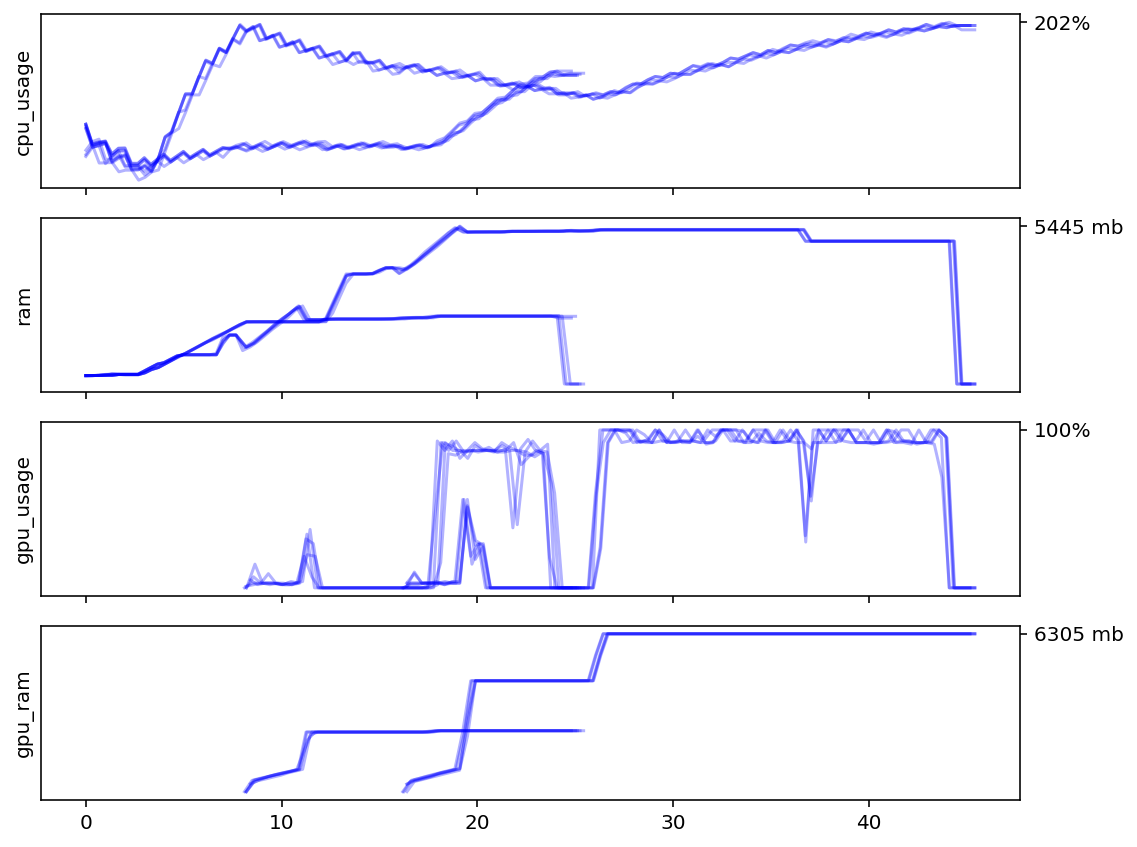

In [40]:
%run -n main
records = query_bench_registry(
    bench_registry,
    input_size=1,
    batch_size=1,
)

records = query_bench_registry(
    bench_registry,
    input_size=2000,
    batch_size=32,
    task=(TERRA),
    model=(RUBERT, RUGPT3_MEDIUM)
)

benches = [
    load_bench_registry(_)
    for _ in records
]

# task=(DANETQA, PARUS, RCB, RWSD, RUSSE, TERRA, LIDIRUS)
# task=(RUCOS, MUSERC)

# model=(RUBERT, RUBERT_CONVERSATIONAL, BERT_MULTILINGUAL)
# model=(RUGPT3_LARGE, RUGPT3_MEDIUM, RUGPT3_SMALL)

show_benches(benches)

## report

In [6]:
%run -n main
bench_groups = list(load_group_benches(bench_registry))

### gpu ram

In [98]:
%run -n main
show_gpu_ram_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
rubert-conversational,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
bert-multilingual,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4
rugpt3-small,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
rugpt3-medium,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4
rugpt3-large,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5


In [109]:
%run -n main
table = show_gpu_ram_bench_report2(bench_groups)
table

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,2.40,2.40,2.39,2.39,2.40,2.39,2.39,2.39,2.39
rubert-conversational,2.40,2.40,2.39,2.39,2.40,2.39,2.39,2.39,2.39
bert-multilingual,2.40,2.40,2.39,2.39,2.40,2.39,2.40,2.39,2.39
rugpt3-small,2.38,2.38,2.36,2.37,2.38,2.36,2.36,2.37,2.36
rugpt3-medium,4.41,4.38,4.39,4.39,4.38,4.38,4.41,4.39,4.39
rugpt3-large,7.49,7.49,7.50,7.50,7.49,7.49,7.51,7.50,7.50


In [100]:
%run -n main
show_gpu_ram_hub_size_bench_report(bench_groups)

,gpu_ram,hub_size,ratio
rubert,2.39,0.66,3.61
rubert-conversational,2.39,0.66,3.61
bert-multilingual,2.39,0.67,3.59
rugpt3-small,2.37,0.51,4.61
rugpt3-medium,4.39,1.70,2.58
rugpt3-large,7.50,3.00,2.50


### time

In [101]:
%run -n main
show_init_time_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,18 18 18 18 27,18 18 20 27 36,18 18 19 26 28,18 19 19 26 26,19 19 19 19 27,18 18 18 26 27,18 18 19 19 27,18 18 18 27 28,18 18 18 18 18
rubert-conversational,18 18 18 35 35,18 18 19 27 27,18 18 18 27 27,18 18 18 27 27,18 18 19 27 27,18 18 18 26 26,18 18 19 27 27,18 18 19 26 27,18 18 18 18 18
bert-multilingual,18 19 19 36 37,19 19 19 20 79,18 18 19 27 27,18 18 19 27 27,19 19 19 27 28,18 18 19 27 27,18 18 19 26 27,19 19 19 27 27,18 18 18 19 19
rugpt3-small,19 19 19 19 33,19 20 20 20 27,19 19 19 19 28,19 19 19 19 28,20 20 20 20 26,19 19 19 19 28,19 20 20 20 28,19 19 19 19 28,19 19 19 19 20
rugpt3-medium,27 27 28 67 70,27 28 28 50 51,27 27 28 47 48,27 27 28 47 47,28 28 28 28 47,27 27 28 48 49,27 28 28 49 52,27 27 27 47 49,27 27 27 27 27
rugpt3-large,41 41 43 117 118,42 42 44 78 84,41 41 43 81 83,41 41 43 53 78,42 42 42 42 79,41 41 44 80 82,41 41 44 78 81,40 41 43 79 80,40 40 41 42 42


In [7]:
%run -n main
show_proc_time_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,17 17 17 17 17,454 456 456 456 457,2 2 2 2 2,6 7 7 7 7,223 223 224 224 224,9 9 9 9 9,19 19 20 20 20,6 7 7 7 7,11 11 12 13 13
rubert-conversational,19 19 19 19 20,459 460 461 462 465,3 3 3 3 3,7 7 7 7 7,234 234 235 236 237,9 9 9 9 9,19 20 20 20 20,6 7 7 7 7,12 12 12 12 12
bert-multilingual,22 22 22 22 22,492 493 495 496 497,4 4 4 4 5,10 10 10 10 10,297 298 298 299 300,12 12 12 12 12,23 23 24 24 24,10 10 10 10 11,15 15 15 15 15
rugpt3-small,21 21 21 21 54,463 465 465 468 477,2 2 2 2 11,7 7 7 7 16,259 259 260 261 261,12 12 12 13 21,19 19 19 19 28,6 6 6 6 15,11 11 11 11 11
rugpt3-medium,44 44 45 45 45,1127 1127 1128 1128 1128,7 7 7 7 8,19 20 20 20 20,604 605 605 605 605,19 19 19 19 19,29 29 29 29 29,18 18 18 18 18,19 19 19 19 19
rugpt3-large,74 75 75 75 78,528 933 1988 1992 1992,14 14 15 15 15,37 38 38 38 38,200 1055 1057 1059,12 26 27 27 27,40 40 41 41 41,33 33 33 33 33,29 29 29 29 29


In [8]:
%run -n main
table = show_rps_bench_report(bench_groups)
table

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,118,4,1070,295,9,226,102,297,165
rubert-conversational,103,4,718,289,8,225,101,302,171
bert-multilingual,90,4,451,194,7,164,85,195,136
rugpt3-small,97,4,872,289,8,163,105,319,176
rugpt3-medium,45,2,270,102,3,106,70,111,106
rugpt3-large,27,1,137,53,2,75,49,61,69


# score perf

In [19]:
# %run -n main
# show_score_perf(docker_scores, leaderboard, bench_groups)